# Before running this notebook
Although it is very likely that if you have the following 4 libraries installed: numpy, matplotlib, pandas and scipy, the notebook should work. In case it doesn't, all the packages are in the requirements.txt file, you may try creating your own virtual environment and then running:

```
pip install -r requirements.txt
```
after activating the virtual environment. Make sure that you are on python `3.10`

In [1]:
#importing all the relevant packages
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from numpy.typing import NDArray
import pandas as pd
from scipy.integrate import solve_ivp

# Implementing the SEIR model

In [2]:
#This might be a bit overkill

@dataclass
class SEIRParams:
    """
    The model params for the SEIR.

    Parameters
    ----------
    alpha: float
    Transition rate from Exposed to Infected.

    beta: float
    The force of infection.

    gamma: float
    The rate of recovery from the infection.

    N: int
    Size of the population

    Attributes
    ---------
    alpha: float
    Transition rate from Exposed to Infected.

    beta: float
    .

    gamma: float
    The rate of recovery from the infection.

    N: int
    Size of the population

    """
    alpha:float
    beta:float
    gamma:float
    N: int

    def updatebeta(self, newbeta)->None:
        self.beta = newbeta
        return None


def seir_diff(t, state:NDArray, seirparams: SEIRParams)->NDArray:
    """
    The difference function, returns the change of number of individuals in a
    compartment per day.

    Parameters
    ---------
    state: NDArray
        The state array of length four, containing the number of individuals in
        rach of the compartment.

    seirparams:SEIRParams
        The SEIRParams object containing the parameters of the SEIR model.
    """
    assert state.ndim ==1
    assert state.shape[0] == 4
    alpha = seirparams.alpha
    beta = seirparams.beta
    gamma = seirparams.gamma
    N = seirparams.N
    return np.array([
        -beta*state[0]*state[2]/N,
        beta*state[0]*state[2]/N - alpha*state[1],
        alpha*state[1] - gamma*state[2],
        gamma*state[2]
        ])


In [3]:
#defining the simulation constants
N = 70000000
alpha = 1/5.8 # days inverse
gamma = 1/5 # days inverse

In [4]:
#plugging in the beta value by hand
beta = 1
# initialise the parameters of the SEIR simulation
seirparam = SEIRParams(
    alpha = alpha,
    beta = beta,
    gamma=gamma,
    N =N
)

print(seirparam)

SEIRParams(alpha=0.1724137931034483, beta=1, gamma=0.2, N=70000000)


In [5]:
#define some initial condition
e, inf, r = 100, 1000, 0
initcondition = [N-e-inf-r, e, inf, r]
# Solve the differential equations
tspan  = (0, 80)
teval = np.linspace(tspan[0], tspan[1], tspan[1]+1)
soln = solve_ivp(
    fun=seir_diff,
    t_span=(0,80),
    t_eval=teval,
    y0 = initcondition,
    args = (seirparam,)
    )

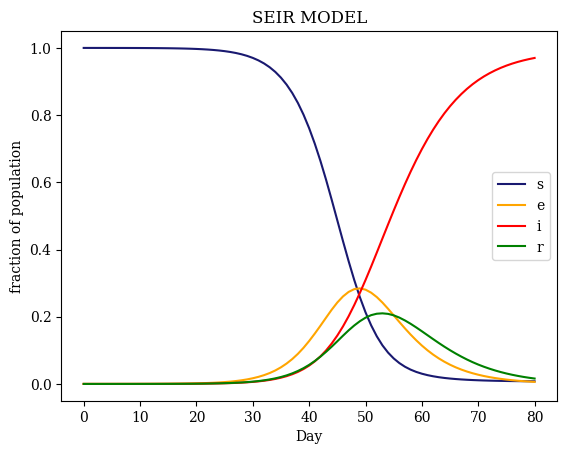

In [6]:
plt.rcParams['font.family'] = 'serif'
colors = ['midnightblue', 'orange', 'red', 'green']
plt.plot(soln.t, soln.y[0]/N, label = 's', color = colors[0])
plt.plot(soln.t, soln.y[1]/N, label = 'e', color = colors[1])
plt.plot(soln.t, soln.y[3]/N, label = 'i', color = colors[2])
plt.plot(soln.t, soln.y[2]/N, label = 'r', color = colors[3])
plt.title('SEIR MODEL')
plt.xlabel('Day')
plt.ylabel('fraction of population')
plt.legend()
# plt.savefig('All_q_1.png', bbox_inches = 'tight')
plt.show()

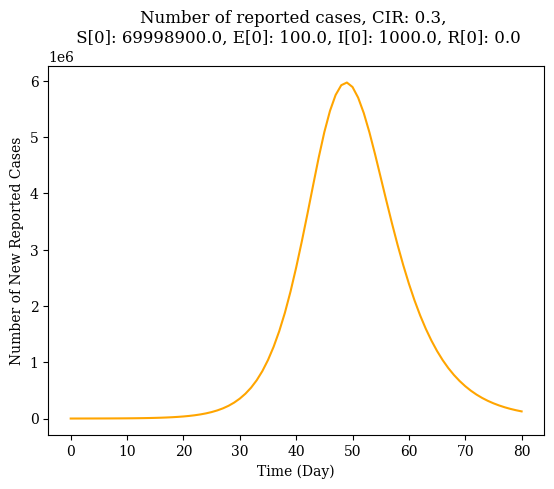

In [7]:
cir = 0.3
plt.title(f'Number of reported cases, CIR: {cir}, \n S[0]: {soln.y[0,0]}, E[0]: {soln.y[1,0]}, I[0]: {soln.y[2,0]}, R[0]: {soln.y[3,0]}')
plt.plot(soln.t, soln.y[1]*cir, color = colors[1])
plt.ylabel("Number of New Reported Cases")
plt.xlabel("Time (Day)")
# plt.savefig('Reported_q_1.png', bbox_inches = 'tight')
plt.show()

In [8]:
#just checking if at all the points the sum
# fraction of people in each compartment adds up to one
assert np.all(np.isclose((soln.y[0]/N+\
soln.y[1]/N+\
soln.y[3]/N+\
soln.y[2]/N), 1))

# Loading the data

In [9]:
dataframe = pd.read_csv('cases.csv')

In [10]:
dataframe.dtypes

state         object
2020-04-01     int64
2020-04-02     int64
2020-04-03     int64
2020-04-04     int64
               ...  
2022-01-25     int64
2022-01-26     int64
2022-01-27     int64
2022-01-28     int64
2022-01-29     int64
Length: 670, dtype: object

In [11]:
# I am assuming that the data is already clean and
# the dates are ordered such that i can just do the following
wave_1 = ('2020-06-20','2020-07-31' )
wave_2 = ('2021-03-21','2021-04-26' )
wave_3 = ('2022-01-01','2022-01-20' )

#get the indices of columns corrsponding to the waves
wave_1_inds = (dataframe.columns.get_loc(wave_1[0]),
               dataframe.columns.get_loc(wave_1[1])
)
wave_2_inds = (dataframe.columns.get_loc(wave_2[0]),
               dataframe.columns.get_loc(wave_2[1])
)
wave_3_inds = (dataframe.columns.get_loc(wave_3[0]),
               dataframe.columns.get_loc(wave_3[1])
)

# get the array of the confirmed cases
wave_1_cases_confirmed = dataframe.iloc[0, wave_1_inds[0]: wave_1_inds[1]].array
wave_1_cases_confirmed = np.array(wave_1_cases_confirmed)
wave_1_new_cases_confirmed = np.diff(wave_1_cases_confirmed) 

wave_2_cases_confirmed = dataframe.iloc[0, wave_2_inds[0]: wave_2_inds[1]].array
wave_2_cases_confirmed = np.array(wave_2_cases_confirmed)
wave_2_new_cases_confirmed = np.diff(wave_2_cases_confirmed)

wave_3_cases_confirmed = dataframe.iloc[0, wave_3_inds[0]: wave_3_inds[1]].array
wave_3_cases_confirmed = np.array(wave_3_cases_confirmed)
wave_3_new_cases_confirmed = np.diff(wave_3_cases_confirmed)


# Compute the running average

In [12]:
# use convolve to compute the running average array
#Define an array of 1/7 for the running average
filter_avg = np.ones(shape= (7,))/7

running_avg_wave_1_new_confirmed = np.convolve(
    wave_1_new_cases_confirmed,
    filter_avg,
    mode = 'valid'
    ).astype(float)

running_avg_wave_2_new_confirmed = np.convolve(
    wave_2_new_cases_confirmed,
    filter_avg,
    mode = 'valid'
    ).astype(float)

running_avg_wave_3_new_confirmed = np.convolve(
    wave_3_new_cases_confirmed,
    filter_avg,
    mode = 'valid'
    ).astype(float)
# np.convolve()

In [13]:
# define the loss function
# Why does this loss function work?


def loss_function(
        unknowns_estimate: tuple|list,
        knowns:tuple|list,
        steps:int,
        new_reported_cases_perday_winavg: NDArray
        )->float:
    """
    The loss function for computing the parameters
    of the SEIR model.
    
    Parameters
    ----------
    unknowns_estimate: tuple|list
        The unknown parameters for the seir simulation: (beta, E[0], I[0], R[0], CIR).
    knowns: tuple|list
        The known parameters, _alpha_, _gamma_ and N for the seir simulation
        passed in the same order in form of a tuple.
    steps: int
        The number of days to simulate the seir model for.
    new_reported_cases_perday_winavg: NDArray
        The number of confirmed new daywise cases.
    """
    # Unpacking the known and unknown params for
    # more readability
    alpha, gamma, N = knowns
    beta, e_ini, inf_ini, recovered_ini, cir = unknowns_estimate
    # Define s(0) = N - e-i-r
    s_ini = N - e_ini - inf_ini- recovered_ini
    # Defining the parameters for the simulation
    seirparam = SEIRParams(
        alpha= alpha,
        beta=beta,
        gamma=gamma,
        N=N
    )
    # the _surmised_ initial condition
    initcondition = np.array([s_ini, e_ini, inf_ini, recovered_ini])
    teval = np.linspace(0,steps-1, steps)
    solution = solve_ivp(
        fun= seir_diff,
        t_span = (teval[0], teval[-1]),
        t_eval= teval,
        y0=initcondition,
        args=(seirparam,)
    )
    assert solution.y.shape[1] == steps
    # "Theoretically" predicted confirmed infections per day
    e_t = cir*solution.y[1,:-1]*alpha
    del solution
    # get the running average
    filter_conv = np.ones((7,))/7
    predicted_confired_cases_per_day_winavg = np.convolve(
        filter_conv,
        e_t,
        mode= 'valid'
        )
    #compute the loss and return
    loss = np.sum((np.log(new_reported_cases_perday_winavg)-np.log(predicted_confired_cases_per_day_winavg))**2)
    return loss

    

## WAVE-1


In [14]:
from scipy import optimize
# Use a optimizer to compute the unknown parameters

# for the first wave
first_wave_constraints = (
    {'type': 'eq', 'fun': lambda x: x[3] - 0},
    {'type': 'ineq', 'fun': lambda x: x[0] - 0},
    {'type': 'ineq', 'fun': lambda x: x[1] - 0},
    {'type': 'ineq', 'fun': lambda x: x[2] - 0},
    {'type': 'ineq', 'fun': lambda x: N - x[1]},
    {'type': 'ineq', 'fun': lambda x: N - x[2]},
    {'type': 'ineq', 'fun': lambda x: N - x[1]},
    {'type': 'ineq', 'fun': lambda x: N - x[1]- x[2]- x[3]},
    {'type': 'ineq', 'fun': lambda x: N - x[1]- x[2]- x[3]},
    {'type': 'ineq', 'fun': lambda x: x[4]-1/30},
    {'type': 'ineq', 'fun': lambda x: 1/12-x[4]},
)

knowns = ( alpha, gamma, N)
steps = wave_1_cases_confirmed.shape[0]
print(f' Steps: {steps}')
argstopass = (
    knowns,
    steps,
    running_avg_wave_1_new_confirmed
)
# np.log()
initialguess = [1, 400, 200, 0, 1/20]
res1_wave = optimize.minimize(
    fun= loss_function,
    x0= initialguess,
    args= argstopass,
    constraints= first_wave_constraints
    )
if res1_wave.success:
    print("Success!")
else:
    print("Fail!")

 Steps: 41
Success!


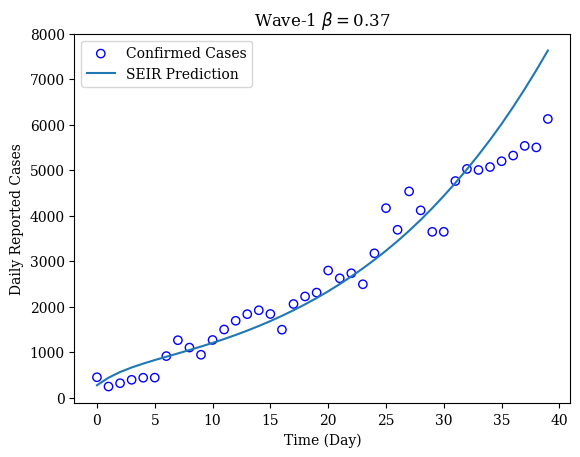

In [15]:
#unpack all the parameters we found
params_wave_1 = res1_wave.x
beta_wave_1, exposed_wave_1, infected_wave_1, recovered_wave_1, cir_wave_1 = params_wave_1

# simulate the wave-1 of the pandemic
exposed_wave_1 = int(exposed_wave_1)
infected_wave_1 = int(infected_wave_1)
recovered_wave_1 = int(recovered_wave_1)
seirparam = SEIRParams(
    alpha=alpha,
    beta=beta_wave_1,
    gamma=gamma,
    N = N
)


steps_wave_1 = wave_1_new_cases_confirmed.shape[0]
teval = np.linspace(0, steps_wave_1-1, steps_wave_1)
init_condition_wave_1 = np.array(
    (
    N - exposed_wave_1- infected_wave_1-recovered_wave_1,
    exposed_wave_1,
    infected_wave_1,
    recovered_wave_1
    )
    )
solution_wave_1 = solve_ivp(
    fun = seir_diff,
    args=(seirparam,),
    t_span= (teval[0], teval[-1]),
    t_eval= teval,
    y0 = init_condition_wave_1
)
reported_theoretical_cases = solution_wave_1.y[1]*alpha*cir_wave_1
plt.scatter(teval, wave_1_new_cases_confirmed, label = 'Confirmed Cases', facecolor = 'none', edgecolors='blue')
plt.plot(teval, reported_theoretical_cases, label = 'SEIR Prediction')
plt.xlabel('Time (Day)')
plt.ylabel('Daily Reported Cases')
# plt.title('Wave-1')
plt.title('Wave-1 '+r"$\beta = $"+ f"{beta_wave_1:.2}")

plt.legend()
# plt.savefig('wave_1_predicted.png', bbox_inches = 'tight', dpi = 300)
plt.show()

## WAVE-2

In [16]:
from scipy import optimize
# Use a optimizer to compute the unknown parameters

# defining the constraints for the second wave
second_wave_constraints = (
    {'type': 'ineq', 'fun': lambda x: x[3] - 0.156*N},
    {'type': 'ineq', 'fun': lambda x: 0.30*N - x[3]},
    {'type': 'ineq', 'fun': lambda x: x[0] - 0},
    {'type': 'ineq', 'fun': lambda x: x[1] - 0},
    {'type': 'ineq', 'fun': lambda x: x[2] - 0},
    {'type': 'ineq', 'fun': lambda x: N - x[1]},
    {'type': 'ineq', 'fun': lambda x: N - x[2]},
    {'type': 'ineq', 'fun': lambda x: N - x[1]},
    {'type': 'ineq', 'fun': lambda x: N - x[1]- x[2]- x[3]},
    {'type': 'ineq', 'fun': lambda x: N - x[1]- x[2]- x[3]},
    {'type': 'ineq', 'fun': lambda x: x[4]-1/30},
    {'type': 'ineq', 'fun': lambda x: 1/12-x[4]},
)

knowns = ( alpha, gamma, N)
steps = wave_2_cases_confirmed.shape[0]
print(f' Steps: {steps}')
argstopass = (
    knowns,
    steps,
    running_avg_wave_2_new_confirmed
)
# np.log()
initialguess = [1, 400, 200, 0.20*N, 1/20]
res2_wave = optimize.minimize(
    fun= loss_function,
    x0= initialguess,
    args= argstopass,
    constraints= second_wave_constraints
    )
if res2_wave.success:
    print("Success!")
else:
    print("Fail!")

 Steps: 36
Success!


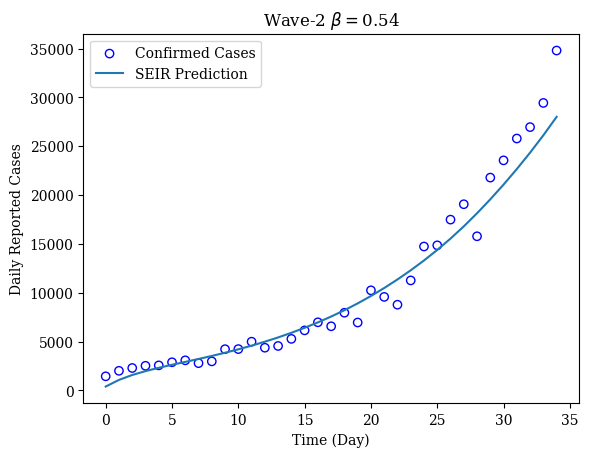

In [17]:
params_wave_2 = res2_wave.x
beta_wave_2, exposed_wave_2, infected_wave_2, recovered_wave_2, cir_wave_2 = params_wave_2

# simulate the wave-1 of the pandemic
exposed_wave_2 = int(exposed_wave_2)
infected_wave_2 = int(infected_wave_2)
recovered_wave_2 = int(recovered_wave_2)
seirparam = SEIRParams(
    alpha=alpha,
    beta=beta_wave_2,
    gamma=gamma,
    N = N
)


steps_wave_2 = wave_2_new_cases_confirmed.shape[0]
teval_wave_2 = np.linspace(0, steps_wave_2-1, steps_wave_2)

#solving the seir equation with the solved parameters
init_condition_wave_2 = np.array(
    (
    N - exposed_wave_2- infected_wave_2-recovered_wave_2,
    exposed_wave_2,
    infected_wave_2,
    recovered_wave_2
    )
    )
solution_wave_2 = solve_ivp(
    fun = seir_diff,
    args=(seirparam,),
    t_span= (teval_wave_2[0], teval_wave_2[-1]),
    t_eval= teval_wave_2,
    y0 = init_condition_wave_2
)
reported_theoretical_cases_wave_2 = solution_wave_2.y[1]*alpha*cir_wave_2



# plt.plot(teval_wave_2, wave_2_new_cases_confirmed, label = 'Confirmed Cases') #, facecolor = 'none', edgecolors='blue')
# plt.plot(teval_wave_2, reported_theoretical_cases_wave_2, label = 'SEIR')

plt.scatter(teval_wave_2, wave_2_new_cases_confirmed, label = 'Confirmed Cases', facecolor = 'none', edgecolors='blue')
plt.plot(teval_wave_2, reported_theoretical_cases_wave_2, label = 'SEIR Prediction')
plt.xlabel('Time (Day)')
plt.ylabel('Daily Reported Cases')
plt.title('Wave-2 '+r"$\beta = $"+ f"{beta_wave_2:.2}")
# plt.title('Wave-2')
plt.legend()
# plt.savefig('wave_2_predicted.png', bbox_inches = 'tight', dpi = 300)
plt.show()

# Wave-3

In [25]:
from scipy import optimize
# Use a optimizer to compute the unknown parameters

# Constraints for the third wave
first_wave_constraints = (
    {'type': 'eq', 'fun': lambda x: x[3] - 0}, # r(0) = 0
    {'type': 'ineq', 'fun': lambda x: x[0] - 0}, #beta, e, i >0
    {'type': 'ineq', 'fun': lambda x: x[1] - 0},
    {'type': 'ineq', 'fun': lambda x: x[2] - 0},
    {'type': 'ineq', 'fun': lambda x: N - x[1]}, #Number should not exceed the total population constraints
    {'type': 'ineq', 'fun': lambda x: N - x[2]},
    {'type': 'ineq', 'fun': lambda x: N - x[1]},
    {'type': 'ineq', 'fun': lambda x: N - x[1]- x[2]- x[3]},
    {'type': 'ineq', 'fun': lambda x: N - x[1]- x[2]- x[3]},
    {'type': 'ineq', 'fun': lambda x: x[4]-1/30}, # 1/30<cir<1/12
    {'type': 'ineq', 'fun': lambda x: 1/12-x[4]},
)

knowns = ( alpha, gamma, N)
steps = wave_3_cases_confirmed.shape[0]
print(f' Steps: {steps}')
argstopass = (
    knowns,
    steps,
    running_avg_wave_3_new_confirmed
)
# np.log()
initialguess = [1, 400, 200, 0, 1/20]
res3_wave = optimize.minimize(
    fun= loss_function,
    x0= initialguess,
    args= argstopass,
    constraints= first_wave_constraints
    )
if res1_wave.success:
    print("Success!")
else:
    print("Fail!")

 Steps: 19
Success!


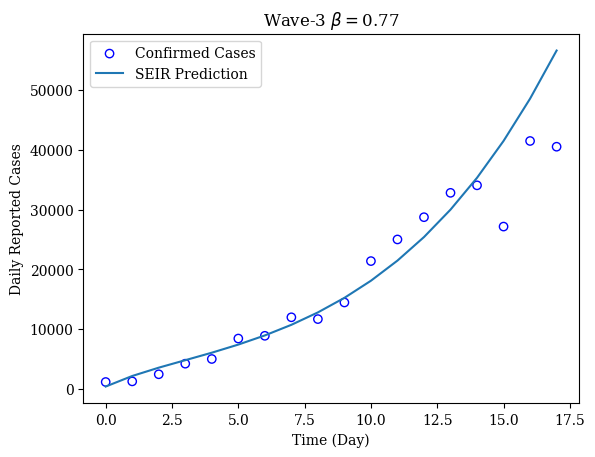

In [26]:
params_wave_3 = res3_wave.x
beta_wave_3, exposed_wave_3, infected_wave_3, recovered_wave_3, cir_wave_3 = params_wave_3

# simulate the wave-1 of the pandemic
exposed_wave_3 = int(exposed_wave_3)
infected_wave_3 = int(infected_wave_3)
recovered_wave_3 = int(recovered_wave_3)
seirparam = SEIRParams(
    alpha=alpha,
    beta=beta_wave_3,
    gamma=gamma,
    N = N
)


steps_wave_3 = wave_3_new_cases_confirmed.shape[0]
teval = np.linspace(0, steps_wave_3-1, steps_wave_3)
init_condition_wave_3 = np.array(
    (
    N - exposed_wave_3- infected_wave_3-recovered_wave_3,
    exposed_wave_3,
    infected_wave_3,
    recovered_wave_3
    )
    )
solution_wave_3 = solve_ivp(
    fun = seir_diff,
    args=(seirparam,),
    t_span= (teval[0], teval[-1]),
    t_eval= teval,
    y0 = init_condition_wave_3
)
reported_theoretical_cases = solution_wave_3.y[1]*alpha*cir_wave_3
plt.scatter(teval, wave_3_new_cases_confirmed, label = 'Confirmed Cases', facecolor = 'none', edgecolors='blue')
plt.plot(teval, reported_theoretical_cases, label = 'SEIR Prediction')
plt.xlabel('Time (Day)')
plt.ylabel('Daily Reported Cases')
plt.title('Wave-3 '+r"$\beta = $"+ f"{beta_wave_3:.2}")
plt.legend()
# plt.savefig('wave_3_predicted.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [ ]:
params_wave_1 = res1_wave.x
beta_wave_1, exposed_wave_1, infected_wave_1, recovered_wave_1, cir_wave_1 = params_wave_1

# simulate the wave-1 of the pandemic
exposed_wave_1 = int(exposed_wave_1)
infected_wave_1 = int(infected_wave_1)
recovered_wave_1 = int(recovered_wave_1)
seirparam = SEIRParams(
    alpha=alpha,
    beta=beta_wave_1,
    gamma=gamma,
    N = N
)


steps_wave_1 = len(dataframe.iloc[0, wave_1_inds[0]-1: wave_2_inds[0]-1])
print(steps_wave_1)
teval = np.linspace(0, steps_wave_1-1, steps_wave_1)
init_condition_wave_1 = np.array(
    (
    N - exposed_wave_1- infected_wave_1-recovered_wave_1,
    exposed_wave_1,
    infected_wave_1,
    recovered_wave_1
    )
    )
solution_wave_1 = solve_ivp(
    fun = seir_diff,
    args=(seirparam,),
    t_span= (teval[0], teval[-1]),
    t_eval= teval,
    y0 = init_condition_wave_1
)
reported_theoretical_cases_wave_1 = solution_wave_1.y[1]*alpha*cir_wave_1

274


In [44]:
params_wave_2 = res2_wave.x
beta_wave_2, exposed_wave_2, infected_wave_2, recovered_wave_2, cir_wave_2 = params_wave_2

# simulate the wave-1 of the pandemic
exposed_wave_2 = int(exposed_wave_2)
infected_wave_2 = int(infected_wave_2)
recovered_wave_2 = int(recovered_wave_2)
seirparam = SEIRParams(
    alpha=alpha,
    beta=beta_wave_2,
    gamma=gamma,
    N = N
)


steps_wave_2 = len(dataframe.iloc[0, wave_2_inds[0]: wave_3_inds[0]-1])
print(steps_wave_2)
teval = np.linspace(0, steps_wave_2-1, steps_wave_2)
init_condition_wave_2 = np.array(
    (
    N - exposed_wave_2- infected_wave_2-recovered_wave_2,
    exposed_wave_2,
    infected_wave_2,
    recovered_wave_2
    )
    )
solution_wave_2 = solve_ivp(
    fun = seir_diff,
    args=(seirparam,),
    t_span= (teval[0], teval[-1]),
    t_eval= teval,
    y0 = init_condition_wave_2
)
reported_theoretical_cases_wave_2 = solution_wave_2.y[1]*alpha*cir_wave_2

285


In [45]:
params_wave_3 = res3_wave.x
beta_wave_3, exposed_wave_3, infected_wave_3, recovered_wave_3, cir_wave_3 = params_wave_3

# simulate the wave-1 of the pandemic
exposed_wave_3 = int(exposed_wave_3)
infected_wave_3 = int(infected_wave_3)
recovered_wave_3 = int(recovered_wave_3)
seirparam = SEIRParams(
    alpha=alpha,
    beta=beta_wave_3,
    gamma=gamma,
    N = N
)


steps_wave_3 = len(dataframe.iloc[0, wave_3_inds[0]:])
print(steps_wave_3)
teval = np.linspace(0, steps_wave_3-1, steps_wave_3)
init_condition_wave_3 = np.array(
    (
    N - exposed_wave_3- infected_wave_3-recovered_wave_3,
    exposed_wave_3,
    infected_wave_3,
    recovered_wave_3
    )
    )
solution_wave_3 = solve_ivp(
    fun = seir_diff,
    args=(seirparam,),
    t_span= (teval[0], teval[-1]),
    t_eval= teval,
    y0 = init_condition_wave_3
)
reported_theoretical_cases_wave_3 = solution_wave_3.y[1]*alpha*cir_wave_3

29


In [ ]:
all_reported_predictions = 

589

In [ ]:
all_cumulative_cases = dataframe.iloc[0, 1:]
all_cumulative_cases = all_cumulative_cases.astype(float)

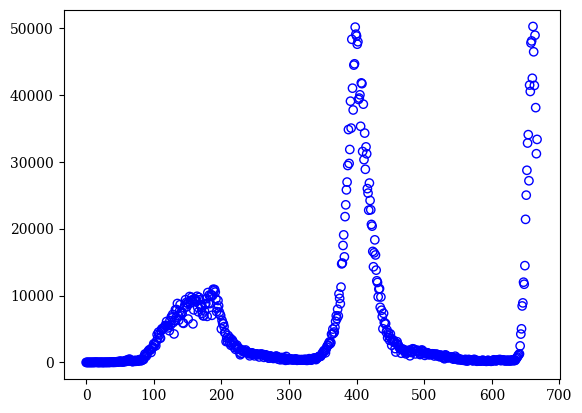

In [ ]:
newcases = np.diff(all_cumulative_cases)
times = np.linspace(0, newcases.shape[0]-1, newcases.shape[0])
plt.scatter(times, newcases, facecolor = 'none', edgecolors='blue')